In [1]:
from IPython.core.display import HTML
def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

In [2]:
import glob
s_dict = {'table_start': 0, 'hand_start': 1, 'off_start': 2}
fi_dict = {'nothing': 0, 'pasta': 1, 'rice': 2, 'water': 3}
fu_dict = {'zero': 0, 'fifty': 1, 'ninety': 2}
b_dict = {'regular': 0, 'textured': 1}
l_dict = {'light0': 0, 'light1': 1}
c_dict = {'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4}
obj_id_dict = {1: 'red cup', 2: 'small white cup',3:'small transparent cup',4:'green glass',5:'wine glass',
              6:'champagne flute glass', 7:'cereal box',8:'biscuit box',9:'tea box', 10: 'sth', 11: 'sth2', 12: 'sth3'} 

valid_dict = {'s': list(s_dict.keys()), 
              'fi': list(fi_dict.keys()),
              'fu': list(fu_dict.keys()),
              'b': list(b_dict.keys()),
              'l': list(l_dict.keys()),
              'c': list(c_dict.keys()),
              'obj_id': list(obj_id_dict.keys()),
             }

def retrieve_data(obj_id, s, fi, fu, b, l, c=[]):
    if ((fi == 'nothing' and (fu =='fifty' or fu =='ninety')) or (fi == 'pasta' and fu == 'zero') or (fi == 'rice' and fu=='zero') or (fi=='water' and fu=='zero')): 
        #print('error')
        return -1
    for i in range(1,len(c),1):
        if c[i] not in valid_dict['c']:
            return -1
    if  (obj_id not in obj_id_dict) or (s not in valid_dict['s']) or (fi not in valid_dict['fi']) or (fu not in valid_dict['fu']) or (b not in valid_dict['b']) or (l not in valid_dict['l']) :
        return -1
    
    _obj_id = obj_id
    _s_id = s_dict[s]
    _fi_id = fi_dict[fi]
    _fu_id = fu_dict[fu]
    _b_id = b_dict[b]
    _l_id = l_dict[l]
    _c_id = []
    
    for i in range(0,len(c),1):
        _c_id.append(c_dict[c[i]])
    if(len(c)==0):
        _c_id = [1,2,3,4]
        
    input_string = 's'+str(_s_id)+'_fi'+str(_fi_id)+'_fu'+str(_fu_id)+'_b'+str(_b_id)+'_l'+str(_l_id)
    
    audio_path = "./*Dataset/"+str(_obj_id)+"/audio/"+input_string+"*"
    audio_list = glob.glob(audio_path)[0]
    
    calib_list = []
    for i in range(0,len(_c_id),1):
        calib_path = "./*Dataset/"+str(_obj_id)+"/calib/"+input_string+'_c'+str(_c_id[i])+'*'
        calib_list.append(glob.glob(calib_path)[0])
    
    depth_list = []
    for i in range(0,len(_c_id),1):
        depth_path = "./*Dataset/"+str(_obj_id)+"/depth/"+input_string+'/c'+str(_c_id[i])+'/*'
        depth_list.append(glob.glob(depth_path))
        
    imu_path = "./*Dataset/"+str(_obj_id)+"/imu/"+input_string+"*"
    imu_list = tuple(glob.glob(imu_path))
    
    
    ir_list=[]
    for i in range(0,len(_c_id),1):
        ir_path = "./*Dataset/"+str(_obj_id)+"/ir/"+input_string+'_c'+str(_c_id[i])+'*'
        ir_list.append(glob.glob(ir_path))
    
    
    rgb_list = []
    for i in range(0,len(_c_id),1):
        rgb_path = "./*Dataset/"+str(_obj_id)+"/rgb/"+input_string+'_c'+str(_c_id[i])+'*'
        rgb_list.append(glob.glob(rgb_path)[0])
    
    
    output_dict = {'audio': audio_list,'calib':calib_list,'depth':depth_list,'imu':imu_list,'ir':ir_list,'rgb':rgb_list}
    return output_dict

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import torch.nn as nn

N_MFCC = 40

def load_and_extract_mfcc(path, window_size=20.0/1000, max_length=30):
    # Load audio data from file
    audio, sample_rate = librosa.load(path, res_type='kaiser_fast')
    
    length = audio.shape[0]
    step_size = int(window_size * sample_rate) # In samples    
    
    # Retrieve the sequence of MFCCs
    sequence = librosa.feature.mfcc(y=audio[:max_length*sample_rate], sr=sample_rate, n_mfcc=N_MFCC,
                                    hop_length=step_size)
    sequence = np.transpose(sequence)
    
    # Normalize the sequence according to its own data
    ### Normalization for each MFCC individually
    _mean = np.mean(sequence, axis=0)
    _std = np.std(sequence, axis=0)
    
    return (sequence - _mean) / _std

aux_dict = {'nothing': np.array([1., 0., 0., 0.]),
            'pasta': np.array([0., 1., 0., 0.]),
            'rice': np.array([0., 0., 1., 0.]),
            'water': np.array([0., 0., 0., 1.])}
data = []
labels = []
#LONGEST_SEQUENCE = 0
for obj_id in range(1, 10):
    print(f"Extracting data from object id: `{obj_id}`")
    for sit in s_dict.keys():
        for fi in fi_dict.keys():
            for fu in fu_dict.keys():
                for b in b_dict.keys():
                    for l in l_dict.keys():
                        try:
                            sample = retrieve_data(obj_id, s=sit, fi=fi, fu=fu, b=b, l=l)
                        except Exception as e:
                            print(f"Failed...: {(obj_id, sit, fi, fu, b, l)}")
                        if sample != -1:
                            seq_data = load_and_extract_mfcc(sample['audio'])
                            data.append(torch.Tensor(seq_data))
                            labels.append(fi_dict[fi])

data = nn.utils.rnn.pad_sequence(data, batch_first=True, padding_value=0)
#labels = torch.LongTensor(labels)
N_SAMPLES = len(data)
print(f"Got {N_SAMPLES} samples in total.")
print(len(data), len(labels))
print(data.shape)
SEQUENCE_LENGTH = data.shape[1]
SEQUENCE_FEATURES = data.shape[2]

Extracting data from object id: `1`
Extracting data from object id: `2`
Extracting data from object id: `3`
Extracting data from object id: `4`
Extracting data from object id: `5`
Extracting data from object id: `6`
Extracting data from object id: `7`
Failed...: (7, 'table_start', 'water', 'fifty', 'regular', 'light0')
Failed...: (7, 'table_start', 'water', 'fifty', 'regular', 'light1')
Failed...: (7, 'table_start', 'water', 'fifty', 'textured', 'light0')
Failed...: (7, 'table_start', 'water', 'fifty', 'textured', 'light1')
Failed...: (7, 'table_start', 'water', 'ninety', 'regular', 'light0')
Failed...: (7, 'table_start', 'water', 'ninety', 'regular', 'light1')
Failed...: (7, 'table_start', 'water', 'ninety', 'textured', 'light0')
Failed...: (7, 'table_start', 'water', 'ninety', 'textured', 'light1')
Failed...: (7, 'hand_start', 'water', 'fifty', 'regular', 'light0')
Failed...: (7, 'hand_start', 'water', 'fifty', 'regular', 'light1')
Failed...: (7, 'hand_start', 'water', 'fifty', 'text

[0 1 2 3] [108 216 216 144]


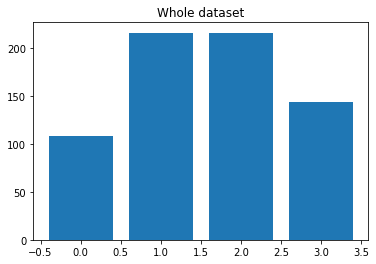

[0 1 2 3] [103 193 194 125]


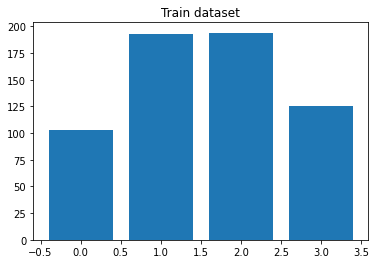

[0.34618768 0.18475301 0.18380067 0.28525864]
[0 1 2 3] [ 5 23 22 19]


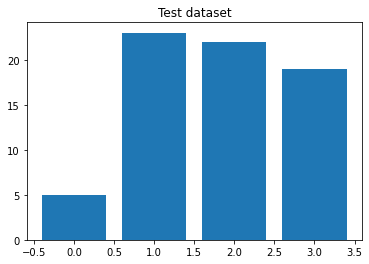

In [4]:
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# Analyze class distribution and 
_classes, counts = np.unique(labels, return_counts=True)
print(_classes, counts)
plt.bar(_classes, counts)
plt.title("Whole dataset")
plt.show()

# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                   test_size=0.1)

_classes, counts = np.unique(y_train, return_counts=True)
n_train_samples = len(y_train)
print(_classes, counts)
plt.bar(_classes, counts)
plt.title("Train dataset")
plt.show()

# Compute the class weights used for training
CLASS_WEIGHTS = np.array([c / n_train_samples for c in counts])
CLASS_WEIGHTS = 1.0 / CLASS_WEIGHTS
CLASS_WEIGHTS = CLASS_WEIGHTS / CLASS_WEIGHTS.sum()
print(CLASS_WEIGHTS)

_classes, counts = np.unique(y_test, return_counts=True)
print(_classes, counts)
plt.bar(_classes, counts)
plt.title("Test dataset")
plt.show()

class AudioDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        assert len(self.x) == len(self.y)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.Tensor(self.x[idx]), self.y[idx]
    
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,
                          num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True,
                          num_workers=0)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from sklearn.metrics import classification_report
target_names = list(fi_dict.keys())
    
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=16,
                               kernel_size=(120, 40),
                               stride=4)
        
        self.conv2 = nn.Conv2d(in_channels=16,
                               out_channels=8,
                               kernel_size=(40, 1),
                               stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        
        self.linear1 = nn.Linear(8*154, 4)
        
    def forward(self, x):
        o1 = F.relu(self.conv1(x))
        o1 = self.dropout1(o1)
        #print(o1.shape)
        o2 = F.relu(self.conv2(o1))
        o2 = self.dropout2(o2)
        #print(o2.shape)
        
        out = self.linear1(o2.view(-1, 8*154))
        
        return out

INTERVAL = 35
    
model = ConvNet()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.00025, momentum=0.9)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(CLASS_WEIGHTS).cuda())

for epoch in range(200):
    print(f"Epoch {epoch+1}")
    running_loss = 0.0
    model.train()
    for i_batch, batch in enumerate(train_loader):
        x, y = batch[0].cuda(), batch[1].cuda()
        x = x.unsqueeze(1) # For conv net

        optimizer.zero_grad()
        
        pred_y = model(x)
        
        loss = criterion(pred_y, y)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        if i_batch % INTERVAL == INTERVAL-1:
            running_loss += running_loss
            print(f"[{epoch+1}, {i_batch+1}]: Loss: {running_loss/INTERVAL:.4f}")
            
    if epoch % 10 == 9:
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            model.eval()
            for batch in test_loader:
                x, y = batch[0].cuda(), batch[1].cuda()
                x = x.unsqueeze(1)
                
                y_true += list(y.cpu().numpy())
                
                pred_y = model(x)
                _, predicted = torch.max(pred_y.data, 1)
                y_pred += list(predicted.cpu().numpy())
                
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        print(len(y_true), len(y_pred))
        print(y_true[0])
        print(classification_report(y_true, y_pred, target_names=target_names))
                
        acc = 100 * correct / total
        print(f"Test Acc: {acc:.3f}%")

Epoch 1
[1, 35]: Loss: 2.7662
[1, 70]: Loss: 8.2679
Epoch 2
[2, 35]: Loss: 2.6730
[2, 70]: Loss: 7.9420
Epoch 3
[3, 35]: Loss: 2.4838
[3, 70]: Loss: 7.4654
Epoch 4
[4, 35]: Loss: 2.4032
[4, 70]: Loss: 7.1036
Epoch 5
[5, 35]: Loss: 2.2158
[5, 70]: Loss: 6.4289
Epoch 6
[6, 35]: Loss: 1.9100
[6, 70]: Loss: 5.5881
Epoch 7
[7, 35]: Loss: 1.5241
[7, 70]: Loss: 4.4865
Epoch 8
[8, 35]: Loss: 1.2406
[8, 70]: Loss: 3.6275
Epoch 9
[9, 35]: Loss: 0.9991
[9, 70]: Loss: 2.8457
Epoch 10
[10, 35]: Loss: 0.7503
[10, 70]: Loss: 2.1993
69 69
2
              precision    recall  f1-score   support

     nothing       0.83      1.00      0.91         5
       pasta       0.79      0.96      0.86        23
        rice       0.82      0.64      0.72        22
       water       0.94      0.89      0.92        19

    accuracy                           0.84        69
   macro avg       0.85      0.87      0.85        69
weighted avg       0.84      0.84      0.84        69

Test Acc: 84.058%
Epoch 11
[11, 35

[84, 70]: Loss: 0.0247
Epoch 85
[85, 35]: Loss: 0.0077
[85, 70]: Loss: 0.0247
Epoch 86
[86, 35]: Loss: 0.0075
[86, 70]: Loss: 0.0219
Epoch 87
[87, 35]: Loss: 0.0059
[87, 70]: Loss: 0.0171
Epoch 88
[88, 35]: Loss: 0.0162
[88, 70]: Loss: 0.0421
Epoch 89
[89, 35]: Loss: 0.0118
[89, 70]: Loss: 0.0320
Epoch 90
[90, 35]: Loss: 0.0097
[90, 70]: Loss: 0.0362
69 69
1
              precision    recall  f1-score   support

     nothing       1.00      1.00      1.00         5
       pasta       0.92      1.00      0.96        23
        rice       0.95      0.86      0.90        22
       water       0.95      0.95      0.95        19

    accuracy                           0.94        69
   macro avg       0.95      0.95      0.95        69
weighted avg       0.94      0.94      0.94        69

Test Acc: 94.203%
Epoch 91
[91, 35]: Loss: 0.0145
[91, 70]: Loss: 0.0432
Epoch 92
[92, 35]: Loss: 0.0062
[92, 70]: Loss: 0.0198
Epoch 93
[93, 35]: Loss: 0.0065
[93, 70]: Loss: 0.0202
Epoch 94
[94, 35]: Lo

[164, 35]: Loss: 0.0031
[164, 70]: Loss: 0.0095
Epoch 165
[165, 35]: Loss: 0.0032
[165, 70]: Loss: 0.0083
Epoch 166
[166, 35]: Loss: 0.0034
[166, 70]: Loss: 0.0105
Epoch 167
[167, 35]: Loss: 0.0045
[167, 70]: Loss: 0.0111
Epoch 168
[168, 35]: Loss: 0.0015
[168, 70]: Loss: 0.0091
Epoch 169
[169, 35]: Loss: 0.0277
[169, 70]: Loss: 0.0616
Epoch 170
[170, 35]: Loss: 0.0045
[170, 70]: Loss: 0.0122
69 69
2
              precision    recall  f1-score   support

     nothing       1.00      1.00      1.00         5
       pasta       0.92      0.96      0.94        23
        rice       0.90      0.86      0.88        22
       water       0.95      0.95      0.95        19

    accuracy                           0.93        69
   macro avg       0.94      0.94      0.94        69
weighted avg       0.93      0.93      0.93        69

Test Acc: 92.754%
Epoch 171
[171, 35]: Loss: 0.0028
[171, 70]: Loss: 0.0180
Epoch 172
[172, 35]: Loss: 0.0104
[172, 70]: Loss: 0.0343
Epoch 173
[173, 35]: Loss: 

In [6]:
#fi_dict = {'nothing': 0, 'pasta': 1, 'rice': 2, 'water': 3}
rev = {0: 'nothing', 1: 'pasta', 2: 'rice', 3: 'water'}

def getModelPrediction(model, path):
    # Loading audio file and extracting MFCC feature
    features = load_and_extract_mfcc(path)
    
    # Padding the sequence
    pad_length = SEQUENCE_LENGTH - features.shape[0]
    features = np.concatenate([features, np.zeros((pad_length, N_MFCC))])

    feat_tensor = torch.Tensor(features)
    feat_tensor = feat_tensor.unsqueeze(0)
    feat_tensor = feat_tensor.unsqueeze(0)

    with torch.no_grad():
        model.eval()
        out = model(feat_tensor.cuda())
        scores = F.softmax(out, dim=1).cpu().numpy()

        _class = np.argmax(scores)
        score = np.max(scores)

        print(f"`{rev[_class]}` with {score*100}% confidence")

        print(np.round(scores, 2))
        
    return _class

In [7]:
import pandas as pd
prediction_list = []
for i in range(10,13,1):
    path = './Dataset/'+str(i)+'/audio/*'
    test_list = natsorted(glob.glob(path))
    for tl in test_list:
        print(tl)
    print("#############")
    #print(test_list)
    for i in range(0,len(test_list),1):
        prediction_list.append(getModelPrediction(model,test_list[i]))
print(len(prediction_list))        


./Dataset/10/audio/0000_audio.wav
./Dataset/10/audio/0001_audio.wav
./Dataset/10/audio/0002_audio.wav
./Dataset/10/audio/0003_audio.wav
./Dataset/10/audio/0004_audio.wav
./Dataset/10/audio/0005_audio.wav
./Dataset/10/audio/0006_audio.wav
./Dataset/10/audio/0007_audio.wav
./Dataset/10/audio/0008_audio.wav
./Dataset/10/audio/0009_audio.wav
./Dataset/10/audio/0010_audio.wav
./Dataset/10/audio/0011_audio.wav
./Dataset/10/audio/0012_audio.wav
./Dataset/10/audio/0013_audio.wav
./Dataset/10/audio/0014_audio.wav
./Dataset/10/audio/0015_audio.wav
./Dataset/10/audio/0016_audio.wav
./Dataset/10/audio/0017_audio.wav
./Dataset/10/audio/0018_audio.wav
./Dataset/10/audio/0019_audio.wav
./Dataset/10/audio/0020_audio.wav
./Dataset/10/audio/0021_audio.wav
./Dataset/10/audio/0022_audio.wav
./Dataset/10/audio/0023_audio.wav
./Dataset/10/audio/0024_audio.wav
./Dataset/10/audio/0025_audio.wav
./Dataset/10/audio/0026_audio.wav
./Dataset/10/audio/0027_audio.wav
./Dataset/10/audio/0028_audio.wav
./Dataset/10/a

`rice` with 100.0% confidence
[[0. 0. 1. 0.]]
`pasta` with 100.0% confidence
[[0. 1. 0. 0.]]
`water` with 99.85116124153137% confidence
[[0. 0. 0. 1.]]
`pasta` with 99.99998807907104% confidence
[[0. 1. 0. 0.]]
`rice` with 100.0% confidence
[[0. 0. 1. 0.]]
`rice` with 100.0% confidence
[[0. 0. 1. 0.]]
`nothing` with 99.94354844093323% confidence
[[1. 0. 0. 0.]]
`water` with 99.99998807907104% confidence
[[0. 0. 0. 1.]]
`rice` with 81.03007078170776% confidence
[[0.   0.   0.81 0.19]]
`pasta` with 99.89711046218872% confidence
[[0. 1. 0. 0.]]
`pasta` with 100.0% confidence
[[0. 1. 0. 0.]]
`rice` with 99.99974966049194% confidence
[[0. 0. 1. 0.]]
`nothing` with 99.4550883769989% confidence
[[0.99 0.   0.   0.  ]]
`nothing` with 88.13961744308472% confidence
[[0.88 0.   0.   0.12]]
`rice` with 98.28097820281982% confidence
[[0.   0.02 0.98 0.  ]]
`rice` with 96.63113951683044% confidence
[[0.   0.03 0.97 0.  ]]
`pasta` with 100.0% confidence
[[0. 1. 0. 0.]]
`water` with 99.9773919582367% 

`pasta` with 99.99685287475586% confidence
[[0. 1. 0. 0.]]
`pasta` with 96.34677171707153% confidence
[[0.   0.96 0.04 0.  ]]
`nothing` with 77.39978432655334% confidence
[[0.77 0.06 0.16 0.  ]]
`pasta` with 98.13141226768494% confidence
[[0.   0.98 0.02 0.  ]]
`nothing` with 97.42359519004822% confidence
[[0.97 0.03 0.   0.  ]]
`pasta` with 99.99998807907104% confidence
[[0. 1. 0. 0.]]
`rice` with 99.63319897651672% confidence
[[0. 0. 1. 0.]]
`rice` with 86.02689504623413% confidence
[[0.   0.14 0.86 0.  ]]
`rice` with 99.97547268867493% confidence
[[0. 0. 1. 0.]]
`pasta` with 99.9639630317688% confidence
[[0. 1. 0. 0.]]
`rice` with 89.25296068191528% confidence
[[0.   0.1  0.89 0.  ]]
`nothing` with 99.99161958694458% confidence
[[1. 0. 0. 0.]]
`pasta` with 99.97778534889221% confidence
[[0. 1. 0. 0.]]
`rice` with 99.90929365158081% confidence
[[0. 0. 1. 0.]]
`pasta` with 99.99936819076538% confidence
[[0. 1. 0. 0.]]
`rice` with 99.29991960525513% confidence
[[0.   0.01 0.99 0.  ]]
`

In [86]:
import pandas as pd
def generatesubmission(feature,data_list):
    df = pd.read_csv('submissions/submissionfile.csv',index_col=0)
    df[feature] = data_list
    df.to_csv('./submissions/submissionfile.csv')

In [87]:
generatesubmission('Filling type',prediction_list)

In [106]:
path = './Dataset/10/audio/0020_audio.wav'
wavPlayer(path)
getModelPrediction(model,path)

`water` with 96.64258360862732% confidence
[[0.   0.   0.03 0.97]]


3

In [108]:
df['Filling type'][5:80]

5     3
6     1
7     1
8     2
9     1
     ..
75    0
76    1
77    1
78    1
79    1
Name: Filling type, Length: 75, dtype: int64

In [111]:
import os
path = './Dataset/3/rgb_jpeg'
os.makedirs(path)

In [114]:
for i in range(1,13):
    path = './Dataset/'+str(i)+'rgb_jpeg/'
    path_list = glob.glob('path')
    for i in range(len(path_list)):
        path2 = path+
    

1
2
3
4
5
6
7
8
9
10
11
12


In [132]:
p_list = glob.glob('./Dataset/1/depth/*/*')
p_list

['./Dataset/1/depth/s0_fi0_fu0_b0_l0/c1',
 './Dataset/1/depth/s0_fi0_fu0_b0_l0/c2',
 './Dataset/1/depth/s0_fi0_fu0_b0_l0/c3',
 './Dataset/1/depth/s0_fi0_fu0_b0_l0/c4',
 './Dataset/1/depth/s0_fi0_fu0_b0_l1/c1',
 './Dataset/1/depth/s0_fi0_fu0_b0_l1/c2',
 './Dataset/1/depth/s0_fi0_fu0_b0_l1/c3',
 './Dataset/1/depth/s0_fi0_fu0_b0_l1/c4',
 './Dataset/1/depth/s0_fi0_fu0_b1_l0/c1',
 './Dataset/1/depth/s0_fi0_fu0_b1_l0/c2',
 './Dataset/1/depth/s0_fi0_fu0_b1_l0/c3',
 './Dataset/1/depth/s0_fi0_fu0_b1_l0/c4',
 './Dataset/1/depth/s0_fi0_fu0_b1_l1/c1',
 './Dataset/1/depth/s0_fi0_fu0_b1_l1/c2',
 './Dataset/1/depth/s0_fi0_fu0_b1_l1/c3',
 './Dataset/1/depth/s0_fi0_fu0_b1_l1/c4',
 './Dataset/1/depth/s0_fi1_fu1_b0_l0/c1',
 './Dataset/1/depth/s0_fi1_fu1_b0_l0/c2',
 './Dataset/1/depth/s0_fi1_fu1_b0_l0/c3',
 './Dataset/1/depth/s0_fi1_fu1_b0_l0/c4',
 './Dataset/1/depth/s0_fi1_fu1_b0_l1/c1',
 './Dataset/1/depth/s0_fi1_fu1_b0_l1/c2',
 './Dataset/1/depth/s0_fi1_fu1_b0_l1/c3',
 './Dataset/1/depth/s0_fi1_fu1_b0_

In [133]:
p_list[0]

'./Dataset/1/depth/s0_fi0_fu0_b0_l0/c1'

In [134]:
p_list[0].replace('depth','rgb_jpeg')

'./Dataset/1/rgb_jpeg/s0_fi0_fu0_b0_l0/c1'

In [135]:
len(p_list)

336

In [140]:
output_list = []
for i in range(len(p_list)):
    output_list.append(p_list[i].replace('depth','rgb_jpeg'))
output_list

['./Dataset/1/rgb_jpeg/s0_fi0_fu0_b0_l0/c1',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b0_l0/c2',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b0_l0/c3',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b0_l0/c4',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b0_l1/c1',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b0_l1/c2',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b0_l1/c3',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b0_l1/c4',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b1_l0/c1',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b1_l0/c2',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b1_l0/c3',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b1_l0/c4',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b1_l1/c1',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b1_l1/c2',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b1_l1/c3',
 './Dataset/1/rgb_jpeg/s0_fi0_fu0_b1_l1/c4',
 './Dataset/1/rgb_jpeg/s0_fi1_fu1_b0_l0/c1',
 './Dataset/1/rgb_jpeg/s0_fi1_fu1_b0_l0/c2',
 './Dataset/1/rgb_jpeg/s0_fi1_fu1_b0_l0/c3',
 './Dataset/1/rgb_jpeg/s0_fi1_fu1_b0_l0/c4',
 './Dataset/1/rgb_jpeg/s0_fi1_fu1_b0_l1/c1',
 './Dataset/1/rgb_jpeg/s0_fi1_fu1_b0_l1/c2',
 './Datase

In [143]:
import os

In [145]:
for i in range(len(output_list)):
    os.makedirs(output_list[i])

In [158]:
for i in range(2,13):
    p_list = glob.glob('./Dataset/'+str(i)+'/depth/*/*')
    output_list = []
    for j in range(len(p_list)):
        output_list.append(p_list[i].replace('depth','rgb_jpeg')
    for k in range(0,len(output_list):
        os.makedirs(output_list[k])
        

SyntaxError: invalid syntax (<ipython-input-158-5d58c7c96247>, line 6)

In [164]:
for k in range(3,13):
    p_list = glob.glob('./Dataset/'+str(k)+'/depth/*/*')
    output_list = []
    for i in range(len(p_list)):
        output_list.append(p_list[i].replace('depth','rgb_jpeg'))
    for j in range(len(output_list)):
        if not os.path.exists(output_list[j]):
            os.makedirs(output_list[j])
    

In [ ]:
for